# 3.16 实战Kaggle比赛：房价预测
动手实战一个Kaggle比赛：房价预测

## 3.16.1 Kaggle比赛
可以在房价预测比赛的网页上了解比赛信息和参赛者成绩，也可以下载数据集并提交自己的预测结果。该比赛的网页地址是 https://www.kaggle.com/c/house-prices-advanced-regression-techniques 。
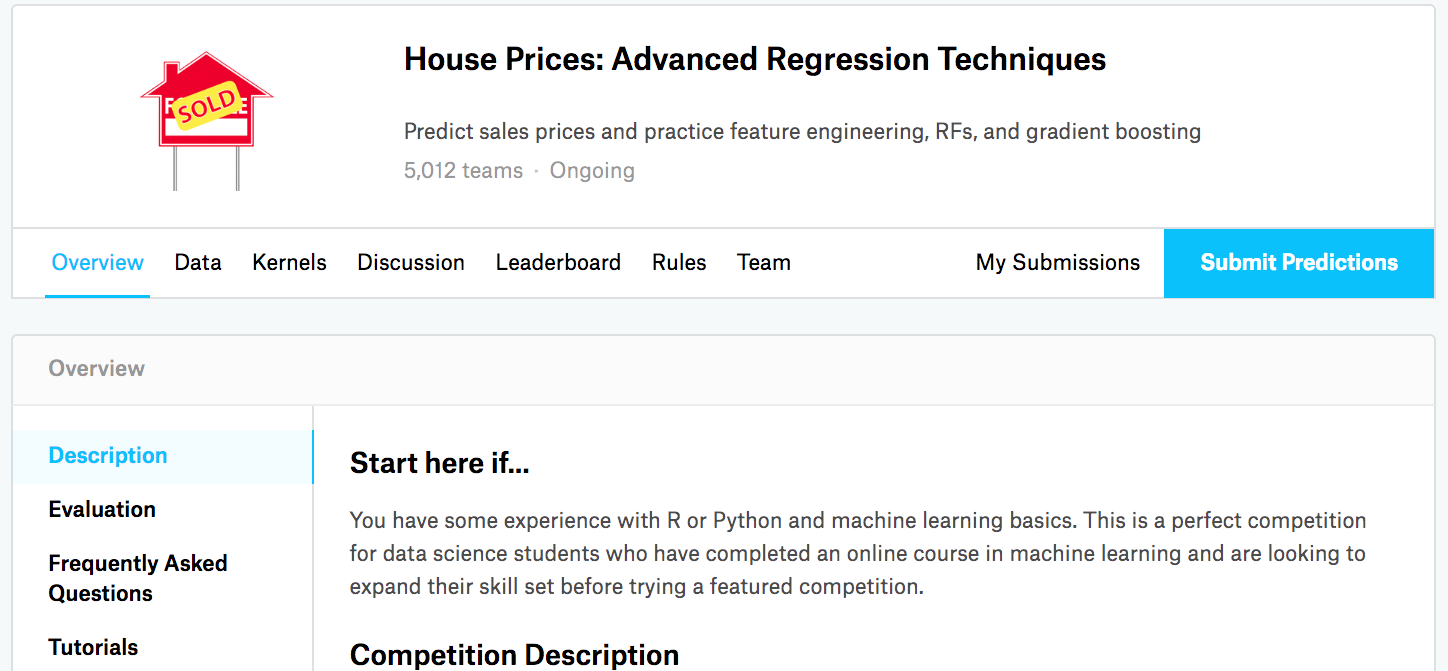

## 3.16.2 获取和读取数据集
比赛数据分为训练数据集和测试数据集。两个数据集都包括每栋房子的特征，如街道类型、建造年份、房顶类型、地下室状况等特征值。这些特征值有连续的数字、离散的标签甚至是缺失值“na”。只有训练数据集包括了每栋房子的价格，也就是标签。

我们将通过pandas库读入并处理数据。

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import d2lzh_pytorch as d2l

print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

1.10.0


假设解压后的数据位于../data/kaggle_house/目录，它包括两个csv文件。下面使用pandas读取这两个文件。

In [2]:
train_data = pd.read_csv('../data/kaggle_house/train.csv')
test_data = pd.read_csv('../data/kaggle_house/test.csv')

训练数据集包括1460个样本、80个特征和1个标签

In [3]:
train_data.shape

(1460, 81)

测试数据集包括1459个样本和80个特征。我们需要将测试数据集中每个样本的标签预测出来。

In [4]:
test_data.shape

(1459, 80)

查看前4个样本的前4个特征、后2个特征和标签（SalePrice）：

In [5]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


可以看到第一个特征是Id，它能帮助模型记住每个训练样本，但难以推广到测试样本，所以我们不使用它来训练。我们将所有的训练数据和测试数据的79个特征按样本连结。

In [6]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [7]:
all_features.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 79, dtype: object

## 3.16.3 预处理数据
我们对连续数值的特征做标准化（standardization）：设该特征在整个数据集上的均值为 $\mu$，标准差为 $\sigma$。那么，我们可以将该特征的每个值先减去 $\mu$再除以$\sigma$得到标准化后的每个特征值。对于缺失的特征值，我们将其替换为该特征的均值。

In [8]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 标准化后，每个数值特征的均值变为0，所以可以直接用0来替换缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)

接下来将离散数值转成指示特征。举个例子，假设特征MSZoning里面有两个不同的离散值RL和RM，那么这一步转换将去掉MSZoning特征，并新加两个特征MSZoning_RL和MSZoning_RM，其值为0或1。如果一个样本原来在MSZoning里的值为RL，那么有MSZoning_RL=1且MSZoning_RM=0。

In [9]:
# dummy_na=True将缺失值也当做合法的特征值并为其创建指示特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

可以看到这一步转换将特征数从79增加到了331。

最后，通过values属性得到NumPy格式的数据，并转成Tensor方便后面的训练。

In [10]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float).view(-1, 1)

## 3.16.4 训练模型
我们使用一个基本的线性回归模型和平方损失函数来训练模型。

In [11]:
loss = torch.nn.MSELoss()

def get_net(feature_num):
    net = nn.Linear(feature_num, 1)
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net

下面定义比赛用来评价模型的对数均方根误差。给定预测值$\hat{y_1},...,\hat{y_n}$和对应的真实标签$y_1,...,y_n$，它的定义为

$$\sqrt{\frac{1}{n}\sum^n_{i=1}(log(y_i)-log(\hat{y_i}))^2}$$

对数均方误差的实现如下：

In [12]:
def log_rmse(net, features, labels):
    with torch.no_grad():
        # 将小于1的值设为1，使得取对数时数值更稳定
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(loss(clipped_preds.log(), labels.log()))
    return rmse.item()

下面的训练函数跟本章中前几节的不同在于使用了Adam优化算法。相对之前使用的小批量随机梯度下降，它对学习率相对不那么敏感。

In [13]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    # 这里使用了Adam优化算法
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    net = net.float()
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
            
    return train_ls, test_ls

## 3.16.5 $K$折交叉验证
下面实现了一个函数，它返回第 i 折交叉验证时所需要的训练和验证数据

In [14]:
def get_k_fold_data(k, i, X, y):
    # 返回第i折交叉验证时所需要的训练和验证数据
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part  # j = i 刚好对应第i折，这一部分作为验证集数据
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
            
    return X_train, y_train, X_valid, y_valid

在$K$折交叉验证中我们训练$K$次并返回训练和验证的平均误差

In [15]:
def k_fold(k, X_train, y_train, num_epochs, 
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train,y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs+1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs+1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' %(i, train_ls[-1], valid_ls[-1]))
        
    return train_l_sum / k, valid_l_sum / k

## 3.16.6 模型选择
使用一组未经调优的超参数并计算交叉验证误差，可以改动这些超参数来尽可能减小平均测试误差

fold 0, train rmse 0.170705, valid rmse 0.156936
fold 1, train rmse 0.162500, valid rmse 0.188471
fold 2, train rmse 0.163878, valid rmse 0.168606
fold 3, train rmse 0.167675, valid rmse 0.154554
fold 4, train rmse 0.163189, valid rmse 0.183436
5-fold validation: avg train rmse 0.165590, avg valid rmse 0.170401


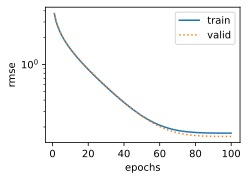

In [16]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print("%d-fold validation: avg train rmse %f, avg valid rmse %f" %(k, train_l, valid_l))

有时候你会发现一组参数的训练误差可以达到很低，但是在$K$折交叉验证上的误差可能反而较高。这种现象很可能是由过拟合造成的。因此，当训练误差降低时，我们要观察$K$折交叉验证上的误差是否也相应降低。

## 3.16.7 预测并在kaggle提交结果
下面定义预测函数。在预测之前，我们会使用完整的训练数据集来重新训练模型，并将预测结果存成提交所需要的格式。

In [17]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print("train rmse %f" % train_ls[-1])
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('./submission.csv', index=False)

设计好模型并调好超参数之后，下一步就是对测试数据集上的房屋样本做价格预测。如果我们得到与交叉验证时差不多的训练误差，那么这个结果很可能是理想的，可以在Kaggle上提交结果。

train rmse 0.162448


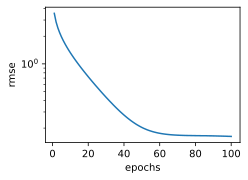

In [18]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)